In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import time
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from imblearn.pipeline import Pipeline as imbPipeline
!pip install category_encoders
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neural_network import MLPClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
values = pd.read_csv('/content/drive/MyDrive/Collab_Files/values.csv')
labels = pd.read_csv('/content/drive/MyDrive/Collab_Files/labels.csv')

### Merge feature vectors and their corresponding label

In [ ]:
df = values.merge(labels, how = 'inner', on = 'building_id')
df

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0,0,0,0,0,0,0,0,2
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0,0,0,0,0,0,0,0,3
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0,0,0,0,0,0,0,0,2


### Checking the types of varibles in the dataset(int,float,object)

In [ ]:

dtypes=pd.DataFrame(values.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=values.nunique()
dtypes["Null Values"]=values.isnull().sum()
dtypes["% null Values"]=values.isnull().sum()/len(values)
dtypes.style.background_gradient(cmap='Set3',axis=0)

,Data Type,Unique Values,Null Values,% null Values
building_id,int64,260601,0,0.000000
geo_level_1_id,int64,31,0,0.000000
geo_level_2_id,int64,1414,0,0.000000
geo_level_3_id,int64,11595,0,0.000000
count_floors_pre_eq,int64,9,0,0.000000
age,int64,42,0,0.000000
area_percentage,int64,84,0,0.000000
height_percentage,int64,27,0,0.000000
land_surface_condition,object,3,0,0.000000
foundation_type,object,5,0,0.000000


### Exploring the statstical fearures of dataset.

In [ ]:

values.describe().T.style.background_gradient(cmap='Set2',low =0.4,high=0.1,axis=0)

,count,mean,std,min,25%,50%,75%,max
building_id,260601.000000,525675.482773,304544.999032,4.000000,261190.000000,525757.000000,789762.000000,1052934.000000
geo_level_1_id,260601.000000,13.900353,8.033617,0.000000,7.000000,12.000000,21.000000,30.000000
geo_level_2_id,260601.000000,701.074685,412.710734,0.000000,350.000000,702.000000,1050.000000,1427.000000
geo_level_3_id,260601.000000,6257.876148,3646.369645,0.000000,3073.000000,6270.000000,9412.000000,12567.000000
count_floors_pre_eq,260601.000000,2.129723,0.727665,1.000000,2.000000,2.000000,2.000000,9.000000
age,260601.000000,26.535029,73.565937,0.000000,10.000000,15.000000,30.000000,995.000000
area_percentage,260601.000000,8.018051,4.392231,1.000000,5.000000,7.000000,9.000000,100.000000
height_percentage,260601.000000,5.434365,1.918418,2.000000,4.000000,5.000000,6.000000,32.000000
has_superstructure_adobe_mud,260601.000000,0.088645,0.284231,0.000000,0.000000,0.000000,0.000000,1.000000
has_superstructure_mud_mortar_stone,260601.000000,0.761935,0.425900,0.000000,1.000000,1.000000,1.000000,1.000000


### Exploring the statstical fearures of dataset (Categories).

In [ ]:

values.describe(include="object").T

,count,unique,top,freq
land_surface_condition,260601,3,t,216757
foundation_type,260601,5,r,219196
roof_type,260601,3,n,182842
ground_floor_type,260601,5,f,209619
other_floor_type,260601,4,q,165282
position,260601,4,s,202090
plan_configuration,260601,10,d,250072
legal_ownership_status,260601,4,v,250939


### Distribution of labels

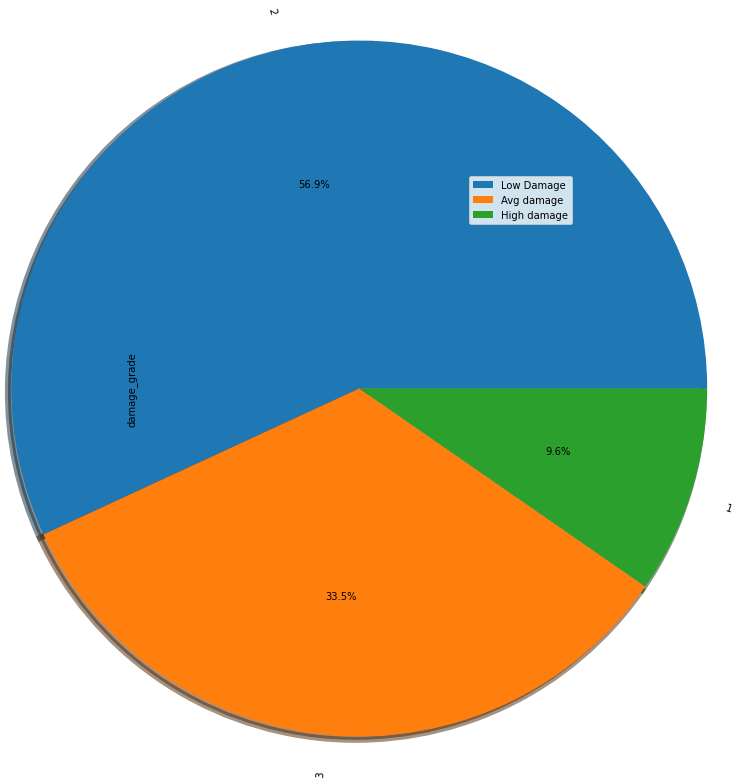

In [ ]:
plt.figure(figsize=(10,8))
labels["damage_grade"].dropna().astype(int).value_counts().plot.pie(autopct="%.1f%%", 
                                                    shadow=True,rotatelabels=True,
                                                    wedgeprops={'linewidth': 6},
                                                    radius=2
                                                    )
plt.legend(["Low Damage","Avg damage","High damage"])
plt.show()

## Correlation between features

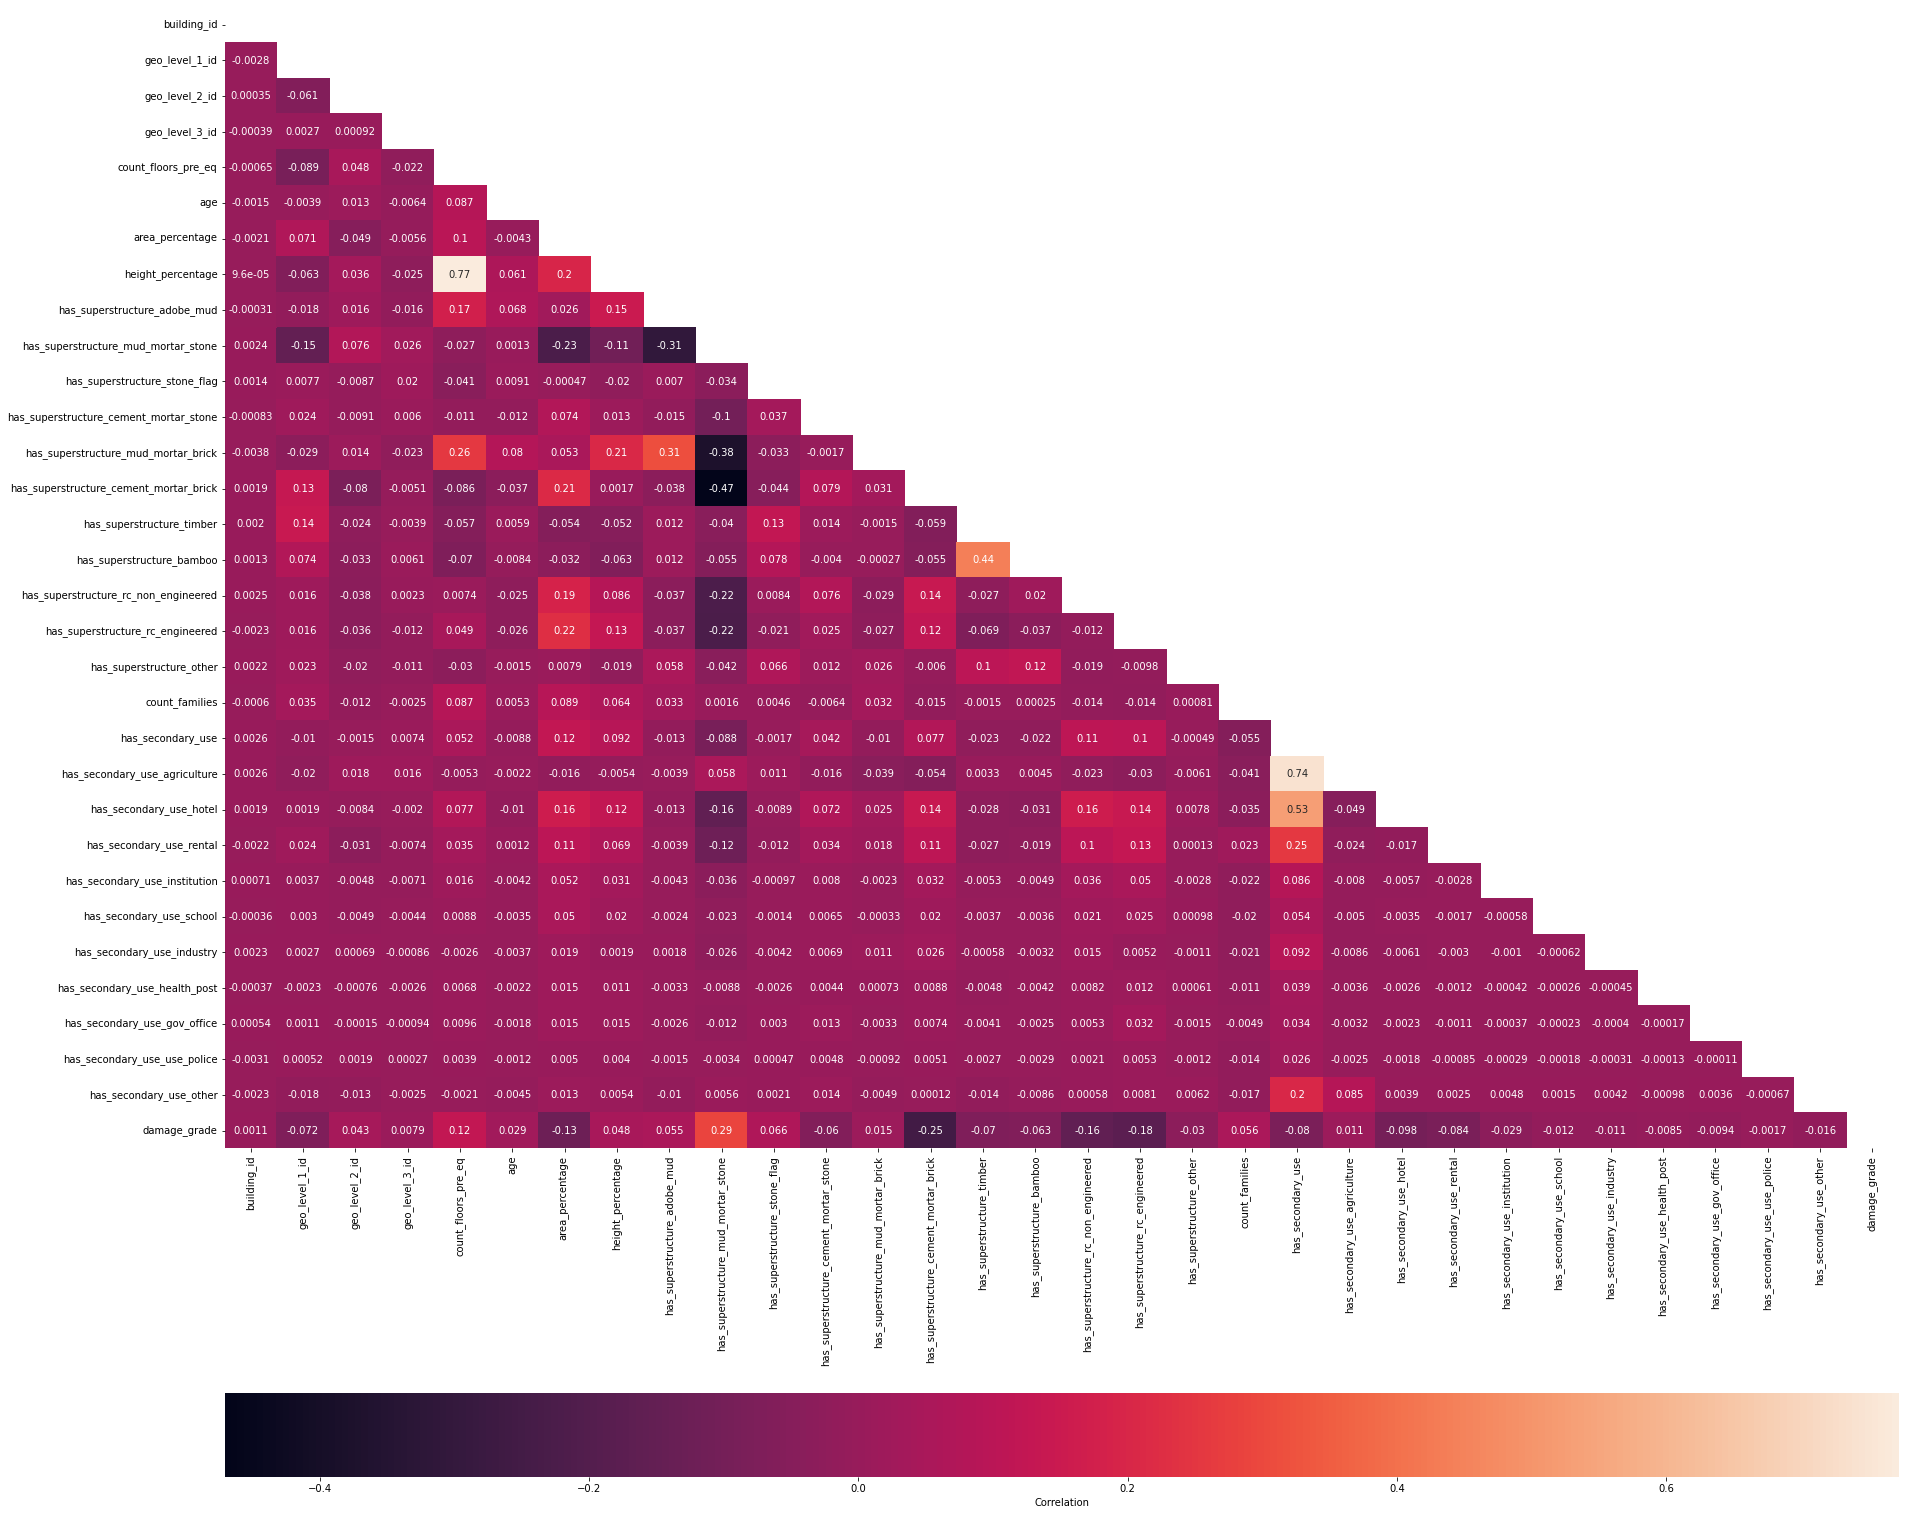

In [ ]:
corr_matrix_mask = np.triu(np.ones_like(df.corr(), dtype=bool))
fig, ax = plt.subplots(figsize  =(30,30))
sns.heatmap(
            df.corr(), ax=ax, annot=True, mask= corr_matrix_mask,
            cbar_kws={"label": "Correlation", "orientation": "horizontal"}
);

## Correlation between features and Damage

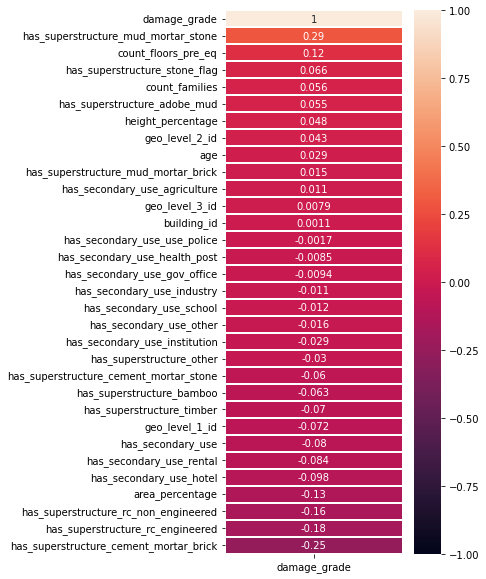

In [ ]:
fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(df.corr()[['damage_grade']].sort_values(by='damage_grade', ascending=False),
           vmin=-1, vmax=1, linewidths=1, annot=True);

## Partition Data and Label

In [ ]:
X = df.drop(['damage_grade', 'building_id'], axis=1)
y = df.damage_grade

## Split to Train and Test

***NOTICE:*** for creating validation dataset we need to split the X_train for the 2nd time to get main X_train and X_validation. but due to lack of system requirements I just used a sample of data to make the models.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Divide the columns by data type

In [ ]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

## Sampling the data (because I couldn't run functions on the whole dataset)

In [ ]:
X_train_sample, X_train_leftover, y_train_sample, y_train_leftover = \
    train_test_split(X_train, y_train, test_size=.9, random_state=42)

## Remove useless columns based on the plots above

In [ ]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')
integer_cols.remove('count_floors_pre_eq')

In [ ]:
X_train_sample

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
243749,6,1168,1311,2,20,11,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
215037,4,821,8173,3,5,6,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0
190124,27,181,7810,6,65,11,12,t,r,n,...,0,0,0,0,0,0,0,0,0,0
137950,4,219,4306,2,5,8,4,t,r,n,...,0,0,0,0,0,0,0,0,0,0
236753,10,960,551,2,10,4,4,t,r,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124682,8,1414,11124,2,20,4,4,t,r,n,...,0,0,0,0,0,0,0,0,0,0
171202,17,51,5945,3,30,6,7,n,r,n,...,0,0,0,0,0,0,0,0,0,0
51069,21,1219,966,2,10,7,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
20606,26,1401,1938,2,15,19,4,t,r,n,...,0,0,0,0,0,0,0,0,0,0


## Transform Data 

In [ ]:
def log_transform(x):
    return np.log(x+1)
    
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

train_transformed = transformer.fit_transform(X_train_sample, y_train_sample)
train_transformed

test_transformed = transformer.fit_transform(X_train_leftover, y_train_leftover)
train_transformed

array([[ 0.        ,  1.        ,  0.        , ...,  0.91090043,
        -0.10769742, -2.89773592],
       [ 0.        ,  1.        ,  0.        , ..., -0.42969126,
         0.88454854,  0.15436808],
       [ 1.        ,  1.        ,  1.        , ...,  0.91090043,
         2.55911646,  0.15436808],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.09757208,
        -0.10769742,  1.93973446],
       [ 0.        ,  0.        ,  0.        , ...,  2.18142554,
        -0.7365438 ,  0.15436808],
       [ 0.        ,  1.        ,  0.        , ...,  0.1953778 ,
        -0.10769742,  0.15436808]])

In [ ]:
train_transformed.shape

(19545, 48)

In [ ]:
params = [
  {'C': [1, 10, 100, 500, 1000], 'gamma':[0.1, 0.3, 0.5, 0.7, 0.9], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 500, 1000], 'kernel': ['linear']},
  {'degree':[2,3,4], 'gamma':[0.01, 0.03, 0.05], 'kernel':['poly']}
]

## Hyperparameter tuning using GridsearchCV and halving method

In [ ]:
clf1 = HalvingGridSearchCV(estimator=SVC(), param_grid=params, cv=2, verbose = 5, scoring='accuracy') 
%time clf1.fit(train_transformed, y_train_sample)
clf1.cv_results_

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 723
max_resources_: 19545
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 39
n_resources: 723
Fitting 2 folds for each of 39 candidates, totalling 78 fits
[CV 1/2] END C=1, gamma=0.1, kernel=rbf;, score=(train=0.814, test=0.687) total time=   0.0s
[CV 2/2] END C=1, gamma=0.1, kernel=rbf;, score=(train=0.814, test=0.684) total time=   0.1s
[CV 1/2] END C=1, gamma=0.3, kernel=rbf;, score=(train=0.903, test=0.654) total time=   0.1s
[CV 2/2] END C=1, gamma=0.3, kernel=rbf;, score=(train=0.911, test=0.648) total time=   0.1s
[CV 1/2] END C=1, gamma=0.5, kernel=rbf;, score=(train=0.936, test=0.623) total time=   0.1s
[CV 2/2] END C=1, gamma=0.5, kernel=rbf;, score=(train=0.945, test=0.623) total time=   0.1s
[CV 1/2] END C=1, gamma=0.7, kernel=rbf;, score=(train=0.958, test=0.612) total time=   0.0s
[CV 2/2] END C=1, gamma=0.7, kernel=rbf;, score=(train=0.961, test=0.604) total time=  

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3]),
 'mean_fit_time': array([2.38105059e-02, 2.80337334e-02, 3.35323811e-02, 3.42136621e-02,
        3.70204449e-02, 1.92329884e-02, 3.35192680e-02, 2.99365520e-02,
        6.01258278e-02, 7.47252703e-02, 5.80132008e-02, 5.28334379e-02,
        8.40346813e-02, 4.58242893e-02, 4.32727337e-02, 4.59094048e-02,
        4.27018404e-02, 2.56949663e-02, 4.36347723e-02, 4.89144325e-02,
        2.49433517e-02, 3.28884125e-02, 4.09557819e-02, 5.95276356e-02,
        8.80477428e-02, 1.91599131e-02, 7.07284212e-02, 6.55926466e-01,
        2.94485211e+00, 5.10693610e+00, 1.05152130e-02, 9.96780396e-03,
        1.13488436e-02, 1.18099451e-02, 1.01575851e-02, 1.05497837e-02,
        1.08206272e-02, 1.03383064e-02, 1.36177540e-02, 1.19982123e-01,
        4.31740284e-02, 4.27927971e-02, 6.40133619e-

In [ ]:
clf1.best_params_

{'C': 500, 'kernel': 'linear'}

## Classify using found parameters



In [ ]:
start = time.time()

if clf1.best_params_['kernel'] == 'linear':
  svc_clf = SVC(C=clf1.best_params_['C'], kernel=clf1.best_params_['kernel'])
elif clf1.best_params_['kernel'] == 'poly':
  svc_clf = SVC(degree=clf1.best_params_['degree'],
                gamma=clf1.best_params_['gamma'], 
                kernel=clf1.best_params_['kernel'])
else:
  svc_clf = SVC(C=clf1.best_params_['C'], gamma=clf1.best_params_['gamma'], kernel=clf1.best_params_['kernel'])

svc_clf.fit(train_transformed, y_train_sample)
y_hat = svc_clf.predict(test_transformed)
end = time.time()
print(f'Run time: {end-start}')
print(classification_report(y_train_leftover, y_hat))

In [ ]:
params = {
    'hidden_layer_sizes': [(8,), (16,), (32,), (64,)],
    'activation': ['tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

## Hyperparameter tuning using GridsearchCV and halving method

In [ ]:
clf2 = HalvingGridSearchCV(estimator=MLPClassifier(random_state=1), param_grid=params, cv=2, verbose = 5, scoring='accuracy') 
%time clf2.fit(train_transformed, y_train_sample)
clf2.cv_results_

In [25]:
clf2.best_params_

{'activation': 'tanh',
 'alpha': 0.05,
 'hidden_layer_sizes': (16,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

## Classify using found parameters


In [26]:
start = time.time()
mlp_clf = MLPClassifier(random_state=1,
                        hidden_layer_sizes=clf2.best_params_['hidden_layer_sizes'],
                        activation=clf2.best_params_['activation'],
                        solver=clf2.best_params_['solver'],
                        alpha=clf2.best_params_['alpha'],
                        learning_rate=clf2.best_params_['learning_rate'])
mlp_clf.fit(train_transformed, y_train_sample)
y_hat = mlp_clf.predict(test_transformed)
end = time.time()
print(f'Run time: {end-start}')
print(classification_report(y_train_leftover, y_hat))

Run time: 14.155030965805054
              precision    recall  f1-score   support

           1       0.69      0.46      0.55     16879
           2       0.75      0.83      0.79    100077
           3       0.74      0.68      0.71     58949

    accuracy                           0.74    175905
   macro avg       0.72      0.66      0.68    175905
weighted avg       0.74      0.74      0.74    175905



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.6, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5, random_state=1) # 0.5 x 0.4 = 0.2

In [28]:
train_transformed = transformer.fit_transform(X_train, y_train)

valid_transformed = transformer.fit_transform(X_val, y_val)

test_transformed = transformer.fit_transform(X_test, y_test)

In [29]:
start = time.time()
mlp_clf = MLPClassifier(random_state=1,
                        hidden_layer_sizes=clf2.best_params_['hidden_layer_sizes'],
                        activation=clf2.best_params_['activation'],
                        solver=clf2.best_params_['solver'],
                        alpha=clf2.best_params_['alpha'],
                        learning_rate=clf2.best_params_['learning_rate'])
mlp_clf.fit(train_transformed, y_train)
y_hat = mlp_clf.predict(valid_transformed)
end = time.time()
print(f'Run time: {end-start}')
print(classification_report(y_val, y_hat))

Run time: 22.812982320785522
              precision    recall  f1-score   support

           1       0.69      0.54      0.61      5025
           2       0.75      0.87      0.81     29651
           3       0.80      0.64      0.71     17444

    accuracy                           0.76     52120
   macro avg       0.75      0.68      0.71     52120
weighted avg       0.76      0.76      0.76     52120



In [ ]:
start = time.time()
y_hat = mlp_clf.predict(test_transformed)
end = time.time()
print(f'Run time: {end-start}')
print(classification_report(y_test, y_hat))

In [ ]:
start = time.time()

if clf1.best_params_['kernel'] == 'linear':
  svc_clf = SVC(C=clf1.best_params_['C'], kernel=clf1.best_params_['kernel'])
elif clf1.best_params_['kernel'] == 'poly':
  svc_clf = SVC(degree=clf1.best_params_['degree'],
                gamma=clf1.best_params_['gamma'], 
                kernel=clf1.best_params_['kernel'])
else:
  svc_clf = SVC(C=clf1.best_params_['C'], gamma=clf1.best_params_['gamma'], kernel=clf1.best_params_['kernel'])

svc_clf.fit(train_transformed, y_train)
y_hat = svc_clf.predict(valid_transformed)
end = time.time()
print(f'Run time: {end-start}')
print(classification_report(y_val, y_hat))

In [ ]:
start = time.time()
y_hat = svc_clf.predict(test_transformed)
end = time.time()
print(f'Run time: {end-start}')
print(classification_report(y_test, y_hat))